In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12,8)
import numpy as np
import tensorflow as tf
import keras
import pandas as pd
from keras_tqdm import TQDMNotebookCallback

In [5]:
from keras.preprocessing.sequence import pad_sequences

def data_generator(batch_size, tfrecord, start_frac=0, end_frac=1):
    '''
    Shuffles the Audioset training data and returns a generator of training data and boolean gunshot labels
    batch_size: batch size for each set of training data and labels
    tfrecord: filestring of the tfrecord file to train on
    start_frac: the starting point of the data set to use, as a fraction of total record length (used for CV)
    end_frac: the ending point of the data set to use, as a fraction of total record length (used for CV)
    '''
    max_len=10
    #tfrecord holds data in binary sequence string. 
    records = list(tf.python_io.tf_record_iterator(tfrecord))  #records holds the array of the tfrecord file
    if(tfrecord == '../data/preprocessed/bal_gunspotting_in_school_subset.tfrecord'):
        print("Total audioframes in training dataset:", len(records))
    elif(tfrecord == '../data/preprocessed/eval_gunspotting_in_school_subset.tfrecord'):
        print("Total audioframes in eval dataset:", len(records))
        
    records = records[int(start_frac*len(records)):int(end_frac*len(records))]  # Make train_set & CV_set 
    print("After fractioning:")
    if(tfrecord == '../data/preprocessed/bal_gunspotting_in_school_subset.tfrecord'):
        print("Total audioframes in training dataset:", len(records))
    elif(tfrecord == '../data/preprocessed/eval_gunspotting_in_school_subset.tfrecord'):
        print("Total audioframes in eval dataset:", len(records))
    
    rec_len = len(records)  # this is your train set, rest is CV_set
    
    shuffle = np.random.permutation(range(rec_len))
    num_batches = rec_len//batch_size - 1                      
    j = 0
    
    gun_labels = [426,427,428,429,430,431]
    
    while True:
        X = []
        y = []  
        for idx in shuffle[j*batch_size:(j+1)*batch_size]:
            example = records[idx]
            tf_seq_example = tf.train.SequenceExample.FromString(example)
            example_label = list(np.asarray(tf_seq_example.context.feature['labels'].int64_list.value))
            value_x = any((True for x in example_label if x in gun_labels)) #add f_bin, b_bin, other_bin
            if(value_x==True):
                y.append(1)      #[1,1,0,1,0...] 
            else:
                y.append(0)
                
            n_frames = len(tf_seq_example.feature_lists.feature_list['audio_embedding'].feature)
            audio_frame = []
            for i in range(n_frames):
                audio_frame.append(np.frombuffer(tf_seq_example.feature_lists.feature_list['audio_embedding'].
                                                         feature[i].bytes_list.value[0],np.uint8).astype(np.float32)) # audio_frame gets 128 8 bit numbers on each for loop iteration
            pad = [np.zeros([128], np.float32) for i in range(max_len-n_frames)] 
            # if clip is less than 10 sec, audio_frame is padded with zeros for 
            #rest of the secs to make it to 10 sec.
            
            audio_frame += pad
            X.append(audio_frame) #eg: X[5] will output 5th audioframe 

        j += 1
        if j >= num_batches:
            shuffle = np.random.permutation(range(rec_len))
            j = 0

        X = np.array(X)
        yield X, np.array(y)

In [90]:
#Logistic Regression

In [91]:
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Flatten
from keras import optimizers

lr_model = Sequential()
# lr_model.add(Flatten(input_shape = (10,128)))
lr_model.add(BatchNormalization(input_shape=(10, 128)))
lr_model.add(Flatten())
lr_model.add(Dense(1, activation='sigmoid')) 
adam = optimizers.Adam(lr=0.1)
lr_model.compile(loss = 'binary_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

In [92]:
batch_size=  40 
CV_frac = 0.1
train_gen = data_generator(batch_size,'../data/preprocessed/bal_gunspotting_in_school_subset.tfrecord', 0, 1-CV_frac)
val_gen = data_generator(20,'../data/preprocessed/bal_gunspotting_in_school_subset.tfrecord', 1-CV_frac, 1)
rec_len = 17662 
lr_h = lr_model.fit_generator(train_gen,steps_per_epoch=int(rec_len*(1-CV_frac))//batch_size, epochs=70,validation_data=val_gen, validation_steps=int(rec_len*CV_frac)//20,verbose=1, callbacks=[TQDMNotebookCallback()])

Epoch 1/70


Total audioframes in training dataset: 17662
After fractioning:
Total audioframes in training dataset: 1767
Total audioframes in training dataset: 17662
After fractioning:
Total audioframes in training dataset: 15895
397/397 [==============================] - 9s 24ms/step - loss: 2.5062 - acc: 0.8307 - val_loss: 2.2422 - val_acc: 0.8562
Epoch 2/70


397/397 [==============================] - 6s 16ms/step - loss: 2.7683 - acc: 0.8256 - val_loss: 2.7085 - val_acc: 0.8301
Epoch 3/70


397/397 [==============================] - 6s 16ms/step - loss: 2.4801 - acc: 0.8444 - val_loss: 2.1915 - val_acc: 0.8625
Epoch 4/70


397/397 [==============================] - 8s 19ms/step - loss: 2.7336 - acc: 0.8284 - val_loss: 2.4599 - val_acc: 0.8466
Epoch 5/70


397/397 [==============================] - 8s 21ms/step - loss: 2.5835 - acc: 0.8384 - val_loss: 2.0553 - val_acc: 0.8716
Epoch 6/70


397/397 [==============================] - 7s 18ms/step - loss: 2.7740 - acc: 0.8261 - val_loss: 2.3985 - val_acc: 0.8494
Epoch 7/70


397/397 [==============================] - 7s 17ms/step - loss: 2.5645 - acc: 0.8401 - val_loss: 2.7983 - val_acc: 0.8256
Epoch 8/70


397/397 [==============================] - 7s 19ms/step - loss: 2.6877 - acc: 0.8322 - val_loss: 2.7789 - val_acc: 0.8273
Epoch 9/70


397/397 [==============================] - 6s 16ms/step - loss: 2.6019 - acc: 0.8378 - val_loss: 2.1383 - val_acc: 0.8659
Epoch 10/70


397/397 [==============================] - 7s 17ms/step - loss: 2.5006 - acc: 0.8441 - val_loss: 2.4466 - val_acc: 0.8477
Epoch 11/70


397/397 [==============================] - 6s 16ms/step - loss: 2.4552 - acc: 0.8471 - val_loss: 2.2883 - val_acc: 0.8568
Epoch 12/70


397/397 [==============================] - 6s 16ms/step - loss: 2.3856 - acc: 0.8508 - val_loss: 2.5211 - val_acc: 0.8432
Epoch 13/70


397/397 [==============================] - 6s 16ms/step - loss: 2.3190 - acc: 0.8549 - val_loss: 2.1746 - val_acc: 0.8636
Epoch 14/70


397/397 [==============================] - 6s 15ms/step - loss: 2.3765 - acc: 0.8519 - val_loss: 2.6348 - val_acc: 0.8358
Epoch 15/70


397/397 [==============================] - 6s 15ms/step - loss: 2.2611 - acc: 0.8589 - val_loss: 2.4716 - val_acc: 0.8460
Epoch 16/70


397/397 [==============================] - 6s 16ms/step - loss: 2.3876 - acc: 0.8514 - val_loss: 2.4640 - val_acc: 0.8466
Epoch 17/70


397/397 [==============================] - 6s 16ms/step - loss: 2.7403 - acc: 0.8283 - val_loss: 2.4238 - val_acc: 0.8489
Epoch 18/70


397/397 [==============================] - 6s 16ms/step - loss: 2.3661 - acc: 0.8522 - val_loss: 2.1332 - val_acc: 0.8670
Epoch 19/70


397/397 [==============================] - 6s 16ms/step - loss: 2.2496 - acc: 0.8596 - val_loss: 2.4151 - val_acc: 0.8494
Epoch 20/70


397/397 [==============================] - 6s 16ms/step - loss: 3.0493 - acc: 0.8105 - val_loss: 4.0823 - val_acc: 0.7466
Epoch 21/70


397/397 [==============================] - 6s 16ms/step - loss: 2.9470 - acc: 0.8167 - val_loss: 3.2653 - val_acc: 0.7972
Epoch 22/70


397/397 [==============================] - 7s 16ms/step - loss: 3.2207 - acc: 0.7999 - val_loss: 2.2207 - val_acc: 0.8614
Epoch 23/70


397/397 [==============================] - 6s 16ms/step - loss: 2.3774 - acc: 0.8519 - val_loss: 2.2804 - val_acc: 0.8580
Epoch 24/70


397/397 [==============================] - 6s 16ms/step - loss: 2.2796 - acc: 0.8579 - val_loss: 2.2090 - val_acc: 0.8625
Epoch 25/70


397/397 [==============================] - 6s 16ms/step - loss: 2.2814 - acc: 0.8575 - val_loss: 2.5116 - val_acc: 0.8426
Epoch 26/70


397/397 [==============================] - 7s 18ms/step - loss: 2.2428 - acc: 0.8600 - val_loss: 2.3464 - val_acc: 0.8540
Epoch 27/70


397/397 [==============================] - 6s 15ms/step - loss: 2.2626 - acc: 0.8590 - val_loss: 2.3511 - val_acc: 0.8534
Epoch 28/70


397/397 [==============================] - 7s 17ms/step - loss: 2.2638 - acc: 0.8589 - val_loss: 2.1739 - val_acc: 0.8636
Epoch 29/70


397/397 [==============================] - 7s 17ms/step - loss: 2.1199 - acc: 0.8677 - val_loss: 2.2624 - val_acc: 0.8591
Epoch 30/70


397/397 [==============================] - 7s 18ms/step - loss: 2.1848 - acc: 0.8640 - val_loss: 2.0619 - val_acc: 0.8716
Epoch 31/70


397/397 [==============================] - 7s 16ms/step - loss: 2.2206 - acc: 0.8616 - val_loss: 2.3678 - val_acc: 0.8523
Epoch 32/70


397/397 [==============================] - 7s 17ms/step - loss: 2.2816 - acc: 0.8576 - val_loss: 2.5248 - val_acc: 0.8420
Epoch 33/70


397/397 [==============================] - 7s 17ms/step - loss: 3.1069 - acc: 0.8054 - val_loss: 2.2046 - val_acc: 0.8625
Epoch 34/70


397/397 [==============================] - 7s 18ms/step - loss: 2.2386 - acc: 0.8604 - val_loss: 2.1675 - val_acc: 0.8648
Epoch 35/70


397/397 [==============================] - 7s 18ms/step - loss: 2.3589 - acc: 0.8531 - val_loss: 2.2581 - val_acc: 0.8591
Epoch 36/70


397/397 [==============================] - 7s 17ms/step - loss: 2.4316 - acc: 0.8487 - val_loss: 2.9905 - val_acc: 0.8142
Epoch 37/70


397/397 [==============================] - 7s 17ms/step - loss: 2.4019 - acc: 0.8503 - val_loss: 2.1863 - val_acc: 0.8636
Epoch 38/70


397/397 [==============================] - 6s 16ms/step - loss: 2.3304 - acc: 0.8545 - val_loss: 2.0291 - val_acc: 0.8733
Epoch 39/70


397/397 [==============================] - 7s 17ms/step - loss: 2.4648 - acc: 0.8467 - val_loss: 2.1999 - val_acc: 0.8631
Epoch 40/70


397/397 [==============================] - 7s 19ms/step - loss: 2.2746 - acc: 0.8579 - val_loss: 2.2191 - val_acc: 0.8614
Epoch 41/70


397/397 [==============================] - 7s 18ms/step - loss: 2.1592 - acc: 0.8654 - val_loss: 2.2650 - val_acc: 0.8591
Epoch 42/70


397/397 [==============================] - 7s 18ms/step - loss: 2.3325 - acc: 0.8550 - val_loss: 2.5214 - val_acc: 0.8426
Epoch 43/70


397/397 [==============================] - 8s 19ms/step - loss: 2.3165 - acc: 0.8557 - val_loss: 2.5066 - val_acc: 0.8437
Epoch 44/70


397/397 [==============================] - 7s 18ms/step - loss: 2.4427 - acc: 0.8482 - val_loss: 2.5495 - val_acc: 0.8415
Epoch 45/70


397/397 [==============================] - 8s 19ms/step - loss: 2.3602 - acc: 0.8529 - val_loss: 2.3896 - val_acc: 0.8506
Epoch 46/70


397/397 [==============================] - 7s 18ms/step - loss: 2.2142 - acc: 0.8619 - val_loss: 2.1588 - val_acc: 0.8653
Epoch 47/70


397/397 [==============================] - 7s 19ms/step - loss: 2.3783 - acc: 0.8519 - val_loss: 2.1037 - val_acc: 0.8688
Epoch 48/70


397/397 [==============================] - 7s 19ms/step - loss: 2.4167 - acc: 0.8489 - val_loss: 2.2343 - val_acc: 0.8608
Epoch 49/70


397/397 [==============================] - 7s 18ms/step - loss: 2.4588 - acc: 0.8465 - val_loss: 2.6138 - val_acc: 0.8364
Epoch 50/70


397/397 [==============================] - 7s 17ms/step - loss: 3.1865 - acc: 0.8003 - val_loss: 2.9379 - val_acc: 0.8159
Epoch 51/70


397/397 [==============================] - 7s 17ms/step - loss: 3.3354 - acc: 0.7910 - val_loss: 1.9589 - val_acc: 0.8778
Epoch 52/70


397/397 [==============================] - 8s 19ms/step - loss: 2.2304 - acc: 0.8607 - val_loss: 2.1247 - val_acc: 0.8676
Epoch 53/70


397/397 [==============================] - 8s 19ms/step - loss: 2.2002 - acc: 0.8627 - val_loss: 2.1828 - val_acc: 0.8636
Epoch 54/70


397/397 [==============================] - 7s 17ms/step - loss: 2.3069 - acc: 0.8563 - val_loss: 2.3117 - val_acc: 0.8562
Epoch 55/70


397/397 [==============================] - 8s 19ms/step - loss: 2.2703 - acc: 0.8586 - val_loss: 2.3146 - val_acc: 0.8557
Epoch 56/70


397/397 [==============================] - 7s 17ms/step - loss: 2.3715 - acc: 0.8524 - val_loss: 2.4416 - val_acc: 0.8483
Epoch 57/70


397/397 [==============================] - 7s 18ms/step - loss: 2.2899 - acc: 0.8574 - val_loss: 2.2181 - val_acc: 0.8619
Epoch 58/70


397/397 [==============================] - 7s 18ms/step - loss: 2.2511 - acc: 0.8599 - val_loss: 2.1543 - val_acc: 0.8659
Epoch 59/70


397/397 [==============================] - 7s 18ms/step - loss: 2.2246 - acc: 0.8611 - val_loss: 2.0749 - val_acc: 0.8705
Epoch 60/70


397/397 [==============================] - 7s 18ms/step - loss: 2.2294 - acc: 0.8608 - val_loss: 2.0036 - val_acc: 0.8750
Epoch 61/70


397/397 [==============================] - 7s 18ms/step - loss: 2.0940 - acc: 0.8694 - val_loss: 2.0397 - val_acc: 0.8727
Epoch 62/70


397/397 [==============================] - 7s 17ms/step - loss: 2.1855 - acc: 0.8637 - val_loss: 2.3443 - val_acc: 0.8534
Epoch 63/70


397/397 [==============================] - 7s 17ms/step - loss: 2.3519 - acc: 0.8530 - val_loss: 2.0874 - val_acc: 0.8699
Epoch 64/70


397/397 [==============================] - 7s 17ms/step - loss: 2.2674 - acc: 0.8588 - val_loss: 2.1381 - val_acc: 0.8670
Epoch 65/70


397/397 [==============================] - 7s 17ms/step - loss: 2.3378 - acc: 0.8545 - val_loss: 2.2606 - val_acc: 0.8591
Epoch 66/70


397/397 [==============================] - 7s 18ms/step - loss: 2.2187 - acc: 0.8618 - val_loss: 2.0797 - val_acc: 0.8705
Epoch 67/70


397/397 [==============================] - 7s 18ms/step - loss: 2.1595 - acc: 0.8654 - val_loss: 2.2254 - val_acc: 0.8614
Epoch 68/70


397/397 [==============================] - 7s 17ms/step - loss: 2.1578 - acc: 0.8656 - val_loss: 2.1421 - val_acc: 0.8665
Epoch 69/70


397/397 [==============================] - 7s 18ms/step - loss: 2.2424 - acc: 0.8603 - val_loss: 2.1399 - val_acc: 0.8665
Epoch 70/70


397/397 [==============================] - 7s 17ms/step - loss: 2.2900 - acc: 0.8574 - val_loss: 2.1992 - val_acc: 0.8631


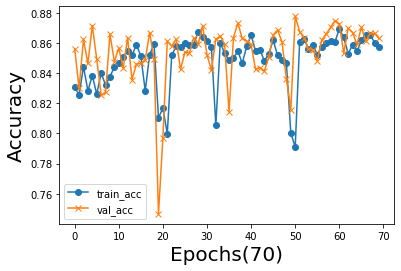

In [93]:
plt.plot(lr_h.history['acc'], 'o-', label='train_acc')
plt.plot(lr_h.history['val_acc'], 'x-', label='val_acc')
plt.xlabel('Epochs(70)', size=20)
plt.ylabel('Accuracy', size=20)
plt.legend()
plt.savefig('results/training_results/LogisticRegression_BinCE_Adam_lr0.1_pochs70.png', dpi = 300)

In [94]:
print("Epochs = 70")
print("val_loss length:",len(lr_h.history['val_loss']))
print("val_acc length:",len(lr_h.history['val_acc']))
print("loss length:",len(lr_h.history['loss']))
print("acc length:",len(lr_h.history['acc']))

print("Average Training loss =", sum(lr_h.history['loss'])/len(lr_h.history['loss']))
print("Average Training accuracy=", sum(lr_h.history['acc'])/len(lr_h.history['acc'])*100)
print("Average validation loss =", sum(lr_h.history['val_loss'])/len(lr_h.history['val_loss']))
print("Average validation accuracy=", sum(lr_h.history['val_acc'])/len(lr_h.history['val_acc'])*100)


from keras.utils import plot_model
plot_model(lr_model, to_file='results/training_results/model_LogisticRegression_BinaryCE_Adam_lr0.1_70Epochs.png')


Epochs = 70
val_loss length: 70
val_acc length: 70
loss length: 70
acc length: 70
Average Training loss = 2.4194436903605876
Average Training accuracy= 84.88682978109908
Average validation loss = 2.3482810797988454
Average validation accuracy= 85.3482142148854


In [58]:
lr_model.save('Models/LogisticRegression_BinaryCE_Adam_lr0.1_50-Epochs.h5')

In [ ]:
# Single Layer Neural Network: 1 Hidden Layer with Relu Activation with batch normalization

In [96]:
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Flatten
# l2 on a dense layer
from keras.regularizers import l2
adam = optimizers.Adam(lr=0.1)

nn_model = Sequential()
nn_model.add(BatchNormalization(input_shape=(10, 128)))
nn_model.add(Flatten())
nn_model.add(Dense(128, activation='relu',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
# nn_model.add(Dense(100, activation='relu'))
nn_model.add(Dense(1, activation='sigmoid'))                 
nn_model.compile(loss='binary_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

In [97]:
batch_size=  40 
CV_frac = 0.1
train_gen = data_generator(batch_size,'../data/preprocessed/bal_gunspotting_in_school_subset.tfrecord', 0, 1-CV_frac)
val_gen = data_generator(20,'../data/preprocessed/bal_gunspotting_in_school_subset.tfrecord', 1-CV_frac, 1)
rec_len = 17662 
nn_h = nn_model.fit_generator(train_gen,steps_per_epoch=int(rec_len*(1-CV_frac))//batch_size, epochs=50,validation_data=val_gen, validation_steps=int(rec_len*CV_frac)//20,verbose=1, callbacks=[TQDMNotebookCallback()])



Epoch 1/50


Total audioframes in training dataset: 17662
After fractioning:
Total audioframes in training dataset: 15895
Total audioframes in training dataset: 17662
After fractioning:
Total audioframes in training dataset: 1767
397/397 [==============================] - 11s 28ms/step - loss: 31.0968 - acc: 0.5194 - val_loss: 21.6697 - val_acc: 0.5500
Epoch 2/50


397/397 [==============================] - 8s 20ms/step - loss: 52.4400 - acc: 0.4997 - val_loss: 101.9284 - val_acc: 0.4932
Epoch 3/50


397/397 [==============================] - 8s 21ms/step - loss: 69.3705 - acc: 0.5018 - val_loss: 13.4682 - val_acc: 0.5080
Epoch 4/50


397/397 [==============================] - 8s 21ms/step - loss: 92.2988 - acc: 0.5122 - val_loss: 162.5331 - val_acc: 0.5085
Epoch 5/50


397/397 [==============================] - 9s 22ms/step - loss: 95.9568 - acc: 0.5003 - val_loss: 292.8453 - val_acc: 0.4881
Epoch 6/50


397/397 [==============================] - 8s 21ms/step - loss: 83.9852 - acc: 0.4977 - val_loss: 8.7976 - val_acc: 0.4949
Epoch 7/50


397/397 [==============================] - 8s 20ms/step - loss: 86.0354 - acc: 0.5041 - val_loss: 44.4122 - val_acc: 0.5074
Epoch 8/50


397/397 [==============================] - 8s 21ms/step - loss: 104.4419 - acc: 0.4992 - val_loss: 320.4317 - val_acc: 0.5278
Epoch 9/50


397/397 [==============================] - 8s 20ms/step - loss: 107.3768 - acc: 0.5213 - val_loss: 53.2346 - val_acc: 0.5119
Epoch 10/50


397/397 [==============================] - 8s 21ms/step - loss: 76.7449 - acc: 0.5241 - val_loss: 12.3163 - val_acc: 0.4875
Epoch 11/50


397/397 [==============================] - 8s 20ms/step - loss: 102.8497 - acc: 0.4984 - val_loss: 68.9621 - val_acc: 0.4903
Epoch 12/50


397/397 [==============================] - 8s 21ms/step - loss: 89.7171 - acc: 0.4975 - val_loss: 9.2155 - val_acc: 0.5040
Epoch 13/50


397/397 [==============================] - 8s 20ms/step - loss: 126.7990 - acc: 0.5024 - val_loss: 69.2767 - val_acc: 0.5028
Epoch 14/50


397/397 [==============================] - 8s 20ms/step - loss: 102.9372 - acc: 0.5287 - val_loss: 41.6716 - val_acc: 0.4892
Epoch 15/50


397/397 [==============================] - 8s 20ms/step - loss: 164.8618 - acc: 0.4952 - val_loss: 511.2717 - val_acc: 0.5034
Epoch 16/50


397/397 [==============================] - 8s 20ms/step - loss: 86.0412 - acc: 0.5013 - val_loss: 637.6478 - val_acc: 0.5233
Epoch 17/50


397/397 [==============================] - 8s 20ms/step - loss: 55.6038 - acc: 0.5003 - val_loss: 31.1735 - val_acc: 0.5017
Epoch 18/50


397/397 [==============================] - 8s 20ms/step - loss: 91.2154 - acc: 0.4974 - val_loss: 120.5280 - val_acc: 0.4983
Epoch 19/50


397/397 [==============================] - 8s 20ms/step - loss: 107.3183 - acc: 0.5016 - val_loss: 8.7002 - val_acc: 0.4949
Epoch 20/50


397/397 [==============================] - 8s 20ms/step - loss: 48.9793 - acc: 0.5067 - val_loss: 7.9969 - val_acc: 0.5097
Epoch 21/50


397/397 [==============================] - 8s 21ms/step - loss: 24.1352 - acc: 0.4996 - val_loss: 8.1097 - val_acc: 0.5006
Epoch 22/50


397/397 [==============================] - 8s 19ms/step - loss: 34.9115 - acc: 0.5023 - val_loss: 8.8204 - val_acc: 0.4977
Epoch 23/50


397/397 [==============================] - 8s 20ms/step - loss: 74.2383 - acc: 0.5021 - val_loss: 8.4674 - val_acc: 0.4795
Epoch 24/50


397/397 [==============================] - 9s 22ms/step - loss: 72.1927 - acc: 0.5016 - val_loss: 15.3028 - val_acc: 0.5051
Epoch 25/50


397/397 [==============================] - 8s 21ms/step - loss: 105.8799 - acc: 0.4958 - val_loss: 333.8828 - val_acc: 0.5045
Epoch 26/50


397/397 [==============================] - 9s 23ms/step - loss: 132.1899 - acc: 0.4989 - val_loss: 843.7790 - val_acc: 0.4983
Epoch 27/50


397/397 [==============================] - 9s 22ms/step - loss: 145.0047 - acc: 0.4940 - val_loss: 8.5989 - val_acc: 0.5040
Epoch 28/50


397/397 [==============================] - 9s 24ms/step - loss: 103.2401 - acc: 0.5079 - val_loss: 22.2137 - val_acc: 0.4875
Epoch 29/50


397/397 [==============================] - 8s 20ms/step - loss: 32.1022 - acc: 0.4992 - val_loss: 8.7327 - val_acc: 0.4881
Epoch 30/50


397/397 [==============================] - 8s 20ms/step - loss: 93.3150 - acc: 0.5048 - val_loss: 8.5754 - val_acc: 0.4915
Epoch 31/50


397/397 [==============================] - 8s 19ms/step - loss: 129.3787 - acc: 0.5002 - val_loss: 34.4676 - val_acc: 0.5136
Epoch 32/50


397/397 [==============================] - 8s 20ms/step - loss: 66.6034 - acc: 0.4980 - val_loss: 87.1154 - val_acc: 0.5080
Epoch 33/50


397/397 [==============================] - 9s 21ms/step - loss: 98.6292 - acc: 0.5062 - val_loss: 69.1788 - val_acc: 0.5028
Epoch 34/50


397/397 [==============================] - 9s 21ms/step - loss: 82.4176 - acc: 0.5026 - val_loss: 13.1913 - val_acc: 0.5074
Epoch 35/50


397/397 [==============================] - 9s 22ms/step - loss: 120.9558 - acc: 0.4972 - val_loss: 124.4199 - val_acc: 0.4989
Epoch 36/50


397/397 [==============================] - 8s 21ms/step - loss: 161.8108 - acc: 0.5029 - val_loss: 184.6572 - val_acc: 0.5318
Epoch 37/50


397/397 [==============================] - 8s 20ms/step - loss: 162.9148 - acc: 0.5108 - val_loss: 303.5718 - val_acc: 0.4875
Epoch 38/50


397/397 [==============================] - 8s 21ms/step - loss: 123.5445 - acc: 0.5219 - val_loss: 17.5484 - val_acc: 0.5727
Epoch 39/50


397/397 [==============================] - 8s 21ms/step - loss: 210.0978 - acc: 0.5416 - val_loss: 156.2795 - val_acc: 0.5773
Epoch 40/50


397/397 [==============================] - 8s 21ms/step - loss: 295.0392 - acc: 0.5893 - val_loss: 177.1130 - val_acc: 0.6114
Epoch 41/50


397/397 [==============================] - 9s 22ms/step - loss: 96.9628 - acc: 0.5582 - val_loss: 34.8013 - val_acc: 0.4983
Epoch 42/50


397/397 [==============================] - 9s 22ms/step - loss: 173.7169 - acc: 0.4957 - val_loss: 23.5152 - val_acc: 0.4506
Epoch 43/50


397/397 [==============================] - 9s 22ms/step - loss: 194.6195 - acc: 0.5400 - val_loss: 21.5556 - val_acc: 0.4920
Epoch 44/50


397/397 [==============================] - 9s 22ms/step - loss: 150.6701 - acc: 0.4833 - val_loss: 388.6999 - val_acc: 0.5182
Epoch 45/50


397/397 [==============================] - 9s 23ms/step - loss: 305.6816 - acc: 0.5920 - val_loss: 48.3803 - val_acc: 0.5114
Epoch 46/50


397/397 [==============================] - 9s 22ms/step - loss: 302.1077 - acc: 0.6569 - val_loss: 63.0297 - val_acc: 0.7028
Epoch 47/50


397/397 [==============================] - 9s 24ms/step - loss: 42.5347 - acc: 0.6564 - val_loss: 1069.0555 - val_acc: 0.5011
Epoch 48/50


397/397 [==============================] - 8s 21ms/step - loss: 214.9381 - acc: 0.5567 - val_loss: 330.8325 - val_acc: 0.5102
Epoch 49/50


397/397 [==============================] - 8s 21ms/step - loss: 216.2914 - acc: 0.5609 - val_loss: 75.3226 - val_acc: 0.6227
Epoch 50/50


397/397 [==============================] - 8s 19ms/step - loss: 251.8681 - acc: 0.5677 - val_loss: 72.5016 - val_acc: 0.6074


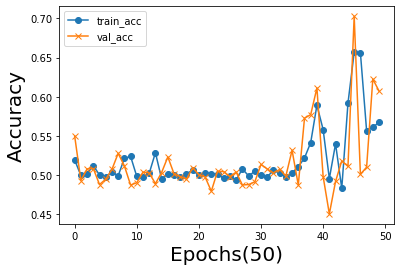

In [98]:
plt.plot(nn_h.history['acc'], 'o-', label='train_acc')
plt.plot(nn_h.history['val_acc'], 'x-', label='val_acc')
plt.xlabel('Epochs(50)', size=20)
plt.ylabel('Accuracy', size=20)
plt.legend()
plt.savefig('results/training_results/NeuralNet/SingleLayerNN__Loss=BinaryCE_50Epochs_lr0.1performance.png', dpi = 300)

In [95]:
print("Epochs = 50")
print("val_loss length:",len(nn_h.history['val_loss']))
print("val_acc length:",len(nn_h.history['val_acc']))
print("loss length:",len(nn_h.history['loss']))
print("acc length:",len(nn_h.history['acc']))

print("Average Training loss =", sum(nn_h.history['loss'])/len(nn_h.history['loss']))
print("Average Training accuracy=", sum(nn_h.history['acc'])/len(nn_h.history['acc'])*100)
print("Average validation loss =", sum(nn_h.history['val_loss'])/len(nn_h.history['val_loss']))
print("Average validation accuracy=", sum(nn_h.history['val_acc'])/len(nn_h.history['val_acc'])*100)


from keras.utils import plot_model
plot_model(nn_model, to_file='results/training_results/NeuralNet/SingleLayerNN__L2RegLoss=BinaryCE_50Epochs_lr0.1Model.png')


Epochs = 50
val_loss length: 50
val_acc length: 50
loss length: 50
acc length: 50
Average Training loss = 7.7246666046083705
Average Training accuracy= 52.063223964246106
Average validation loss = 7.982510943972349
Average validation accuracy= 50.472727398980744


In [76]:
nn_model.save('Models/SingleLayerNN__Loss=BinaryCE_50Epochs_lr0.4.h5')

In [ ]:
## Single Layer NN Model with Mean Squared Logarithmic Error

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Flatten

nn_model = Sequential()
nn_model.add(BatchNormalization(input_shape=(10, 128)))
nn_model.add(Flatten())
nn_model.add(Dense(100, activation='relu'))
nn_model.add(Dense(1, activation='sigmoid'))                 
nn_model.compile(loss='mean_squared_logarithmic_error',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
## Multiclass Logistic Regression

In [ ]:
from bitstring import BitArray  #To perform bit manipulation
from keras.preprocessing.sequence import pad_sequences

def data_generator_multiclass(batch_size, tfrecord, start_frac=0, end_frac=1):
    '''
    Shuffles the Audioset training data and returns a generator of training data and boolean gunshot labels
    batch_size: batch size for each set of training data and labels
    tfrecord: filestring of the tfrecord file to train on
    start_frac: the starting point of the data set to use, as a fraction of total record length (used for CV)
    end_frac: the ending point of the data set to use, as a fraction of total record length (used for CV)
    '''
    max_len=10
    #tfrecord holds data in binary sequence string. 
    records = list(tf.python_io.tf_record_iterator(tfrecord))  #records holds the array of the tfrecord file
    if(tfrecord == '../data/preprocessed/unbaltrain_spotting_gunshots_subset.tfrecord'):
        print("Total audioframes in training dataset:", len(records))
    elif(tfrecord == '../data/preprocessed/eval_spotting_gunshots_subset.tfrecord'):
        print("Total audioframes in eval dataset:", len(records))
        
    records = records[int(start_frac*len(records)):int(end_frac*len(records))]  # Make train_set & CV_set 
    print("After fractioning:")
    if(tfrecord == '../data/preprocessed/unbaltrain_spotting_gunshots_subset.tfrecord'):
        print("Total audioframes in training dataset:", len(records))
    elif(tfrecord == '../data/preprocessed/eval_spotting_gunshots_subset.tfrecord'):
        print("Total audioframes in eval dataset:", len(records))
    
    rec_len = len(records)  # this is your train set, rest is CV_set
    shuffle = np.random.permutation(range(rec_len))
    num_batches = rec_len//batch_size - 1                      
    j = 0
    
    
    classes = ["gun","firework","background", "other"]
    dict_classes = dict.fromkeys(classes)
    
    gun_labels = [426,427,428,429,430,431]
    fireworks_labels = [432,433,434]
    background_labels= [506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526]
    other_labels =[]
    
    while True:
        X = []
        y = []  #add g=[],f=[],b=[],other=[]
        
        for idx in shuffle[j*batch_size:(j+1)*batch_size]:
            example = records[idx]
            tf_seq_example = tf.train.SequenceExample.FromString(example)
            example_label = list(np.asarray(tf_seq_example.context.feature['labels'].int64_list.value))
            dict_classes = {
                "gun":int(any((True for x in example_label if x in gun_labels))),
                "firework":int(any((True for x in example_label if x in fireworks_labels))),
                "background":int(any(True for x in example_label if x in background_labels)),
                "other": 0
            }
            if (sum(dict_classes.values()) == 0):
#                 dict_classes["other"] = 1
                y.append(3)
            elif (sum(dict_classes.values()) >1):
                dict_classes  = dict.fromkeys(dict_classes, 0)
                continue;  # skip this iteration since the audioframe contains co-occurence of our classes 
            elif (sum(dict_classes.values()) == 1):
                if (dict_classes["gun"] == 1):
                    y.append(0)
                if (dict_classes["firework"] == 1):
                    y.append(1)
                if (dict_classes["background"] == 1):
                    y.append(2)
                if (dict_classes["other"] == 1):
                    y.append(3)
                                
            n_frames = len(tf_seq_example.feature_lists.feature_list['audio_embedding'].feature)
            audio_frame = []
            for i in range(n_frames):
                audio_frame.append(np.frombuffer(tf_seq_example.feature_lists.feature_list['audio_embedding'].
                                                         feature[i].bytes_list.value[0],np.uint8).astype(np.float32)) # audio_frame gets 128 8 bit numbers on each for loop iteration
            pad = [np.zeros([128], np.float32) for i in range(max_len-n_frames)] 
            # if clip is less than 10 sec, audio_frame is padded with zeros for 
            #rest of the secs to make it to 10 sec.
            
            audio_frame += pad
            X.append(audio_frame) #eg: X[5] will output 5th audioframe 

        j += 1
        if j >= num_batches:
            shuffle = np.random.permutation(range(rec_len))
            j = 0

        X = np.array(X)
        print("size of X",len(X))
        print("size of y",len(y))
        yield X, np.array(y)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Flatten

multi_lr_model = Sequential()
# lr_model.add(Flatten(input_shape = (10,128)))
# multi_lr_model.add(BatchNormalization(input_shape=(10, 128)))

multi_lr_model.add(Flatten(input_shape=(10, 128)))
#multi_lr_model.add(Flatten())
multi_lr_model.add(Dense(4, activation='softmax'))                
multi_lr_model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])


In [ ]:
batch_size=  40 
CV_frac = 0.1
train_gen = data_generator_multiclass(batch_size,'../data/preprocessed/unbaltrain_spotting_gunshots_subset.tfrecord')#, 0, 1-CV_frac)
val_gen = data_generator_multiclass(20,'../data/preprocessed/eval_spotting_gunshots_subset.tfrecord')#, 1-CV_frac, 1)
rec_len = 22832 
multi_lr_h = multi_lr_model.fit_generator(train_gen,steps_per_epoch=int(rec_len*(1-CV_frac))//batch_size, epochs=50,validation_data=val_gen, validation_steps=int(rec_len*CV_frac)//20,verbose=0, callbacks=[TQDMNotebookCallback()])

In [ ]:
plt.plot(multi_lr_h.history['acc'], 'o-', label='train_acc')
plt.plot(multi_lr_h.history['val_acc'], 'x-', label='val_acc')
plt.xlabel('Epochs(100)', size=18)
plt.ylabel('Accuracy', size=18)
plt.legend()
plt.savefig('results/training_results/LogisticRegression__Loss=sparse_catCE_100Epochs.png', dpi = 300)

In [ ]:
print("Epochs = 100")
print("val_loss length:",len(multi_lr_h.history['val_loss']))
print("val_acc length:",len(multi_lr_h.history['val_acc']))
print("loss length:",len(multi_lr_h.history['loss']))
print("acc length:",len(multi_lr_h.history['acc']))

print("Average Training loss =", sum(multi_lr_h.history['loss'])/len(multi_lr_h.history['loss']))
print("Average Training accuracy=", sum(multi_lr_h.history['acc'])/len(multi_lr_h.history['acc'])*100)
print("Average validation loss =", sum(multi_lr_h.history['val_loss'])/len(multi_lr_h.history['val_loss']))
print("Average validation accuracy=", sum(multi_lr_h.history['val_acc'])/len(multi_lr_h.history['val_acc'])*100)


from keras.utils import plot_model
plot_model(multi_lr_model, to_file='results/training_results/LogisticRegression__Loss=sparse_catCE_100Epochs.png')


In [ ]:
multi_lr_model.save('Models/LogisticRegression__Loss=sparse_catCE_100Epochs.h5')

In [ ]:
#LSTM Single Layer

In [2]:
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout
from keras.layers import LSTM
from keras import regularizers
from keras import optimizers

adam = optimizers.Adam(lr=0.001)
lstm_model = Sequential()
lstm_model.add(BatchNormalization(input_shape=(None, 128)))
lstm_model.add(Dropout(0.5))
lstm_model.add(LSTM(128, activation='relu',
        kernel_regularizer=regularizers.l2(0.01),
        activity_regularizer=regularizers.l2(0.01)))
lstm_model.add(Dense(1, activation='sigmoid'))

# try using different optimizers and different optimizer configs
lstm_model.compile(loss='binary_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [6]:
batch_size=32
CV_frac = 0.1
train_gen = data_generator(batch_size,'../../data/preprocessed/bal_gunspotting_in_school_subset.tfrecord', 0, 1-CV_frac)
val_gen = data_generator(20,'../../data/preprocessed/bal_gunspotting_in_school_subset.tfrecord', 1-CV_frac, 1)

rec_len = 17662

lstm_h = lstm_model.fit_generator(train_gen,steps_per_epoch=int(rec_len*(1-CV_frac))//batch_size, epochs=20, 
                       validation_data=val_gen, validation_steps=int(rec_len*CV_frac)//20,
                       verbose=1, callbacks=[TQDMNotebookCallback()])

Instructions for updating:
Use tf.cast instead.


Epoch 1/20
Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


After fractioning:
After fractioning:
496/496 [==============================] - 29s 59ms/step - loss: 1.6054 - acc: 0.8260 - val_loss: 0.5366 - val_acc: 0.9045
Epoch 2/20


496/496 [==============================] - 25s 50ms/step - loss: 0.4837 - acc: 0.8884 - val_loss: 0.3704 - val_acc: 0.9205
Epoch 3/20


496/496 [==============================] - 28s 57ms/step - loss: 0.4045 - acc: 0.8987 - val_loss: 0.3200 - val_acc: 0.9261
Epoch 4/20


496/496 [==============================] - 26s 53ms/step - loss: 0.3679 - acc: 0.9038 - val_loss: 0.2992 - val_acc: 0.9233
Epoch 5/20


496/496 [==============================] - 27s 54ms/step - loss: 0.3458 - acc: 0.9102 - val_loss: 0.2910 - val_acc: 0.9216
Epoch 6/20


496/496 [==============================] - 28s 56ms/step - loss: 0.3350 - acc: 0.9105 - val_loss: 0.2746 - val_acc: 0.9278
Epoch 7/20


496/496 [==============================] - 27s 55ms/step - loss: 0.3199 - acc: 0.9128 - val_loss: 0.2703 - val_acc: 0.9278
Epoch 8/20


496/496 [==============================] - 27s 55ms/step - loss: 0.3144 - acc: 0.9130 - val_loss: 0.2581 - val_acc: 0.9341
Epoch 9/20


496/496 [==============================] - 26s 52ms/step - loss: 0.3069 - acc: 0.9118 - val_loss: 0.2515 - val_acc: 0.9335
Epoch 10/20


496/496 [==============================] - 27s 54ms/step - loss: 0.2993 - acc: 0.9166 - val_loss: 0.2449 - val_acc: 0.9312
Epoch 11/20


496/496 [==============================] - 26s 51ms/step - loss: 0.2948 - acc: 0.9181 - val_loss: 0.2479 - val_acc: 0.9341
Epoch 12/20


496/496 [==============================] - 28s 57ms/step - loss: 0.2942 - acc: 0.9183 - val_loss: 0.2442 - val_acc: 0.9324
Epoch 13/20


496/496 [==============================] - 27s 55ms/step - loss: 0.2850 - acc: 0.9185 - val_loss: 0.2424 - val_acc: 0.9318
Epoch 14/20


496/496 [==============================] - 26s 52ms/step - loss: 0.2844 - acc: 0.9171 - val_loss: 0.2439 - val_acc: 0.9307
Epoch 15/20


496/496 [==============================] - 29s 58ms/step - loss: 0.2797 - acc: 0.9182 - val_loss: 0.2334 - val_acc: 0.9375
Epoch 16/20


496/496 [==============================] - 28s 56ms/step - loss: 0.2813 - acc: 0.9189 - val_loss: 0.2465 - val_acc: 0.9324
Epoch 17/20


496/496 [==============================] - 31s 62ms/step - loss: 0.2772 - acc: 0.9178 - val_loss: 0.2190 - val_acc: 0.9364
Epoch 18/20


496/496 [==============================] - 26s 52ms/step - loss: 0.2730 - acc: 0.9198 - val_loss: 0.2333 - val_acc: 0.9301
Epoch 19/20


496/496 [==============================] - 27s 54ms/step - loss: 0.2703 - acc: 0.9203 - val_loss: 0.2264 - val_acc: 0.9386
Epoch 20/20


496/496 [==============================] - 27s 55ms/step - loss: 0.2707 - acc: 0.9213 - val_loss: 0.2313 - val_acc: 0.9307



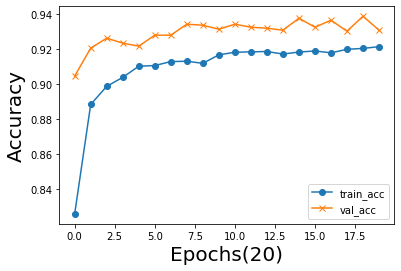

In [14]:
plt.plot(lstm_h.history['acc'], 'o-', label='train_acc')
plt.plot(lstm_h.history['val_acc'], 'x-', label='val_acc')
plt.xlabel('Epochs(20)', size=20)
plt.ylabel('Accuracy', size=20)
plt.legend()
plt.savefig('../results/LSTM/LSTM__Loss=BinCE_lr0.001_20Epochs_performance.png', dpi = 300)

In [11]:
print("Epochs = 20")
print("val_loss length:",len(lstm_h.history['val_loss']))
print("val_acc length:",len(lstm_h.history['val_acc']))
print("loss length:",len(lstm_h.history['loss']))
print("acc length:",len(lstm_h.history['acc']))

print("Average Training loss =", sum(lstm_h.history['loss'])/len(lstm_h.history['loss']))
print("Average Training accuracy=", sum(lstm_h.history['acc'])/len(lstm_h.history['acc'])*100)
print("Average validation loss =", sum(lstm_h.history['val_loss'])/len(lstm_h.history['val_loss']))
print("Average validation accuracy=", sum(lstm_h.history['val_acc'])/len(lstm_h.history['val_acc'])*100)


from keras.utils import plot_model
plot_model(lstm_model, to_file='../results/LSTM/LSTM_Loss=BinCE_20EpochsModel.png')


Epochs = 20
val_loss length: 20
val_acc length: 20
loss length: 20
acc length: 20
Average Training loss = 0.3796796187886128
Average Training accuracy= 90.90032762096773
Average validation loss = 0.27423475399105385
Average validation accuracy= 92.9261356287382


In [13]:
lstm_model.save('../models/1LayerLSTM__Loss=BinCE_20Epochs_july02.h5')

In [103]:
# 3 Layer LSTM network
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout
from keras.layers import LSTM
from keras import regularizers

lstm3_model = Sequential()
lstm3_model.add(BatchNormalization(input_shape=(None, 128)))
lstm3_model.add(Dropout(0.5))

lstm3_model.add(LSTM(64, activation='relu',
        kernel_regularizer=regularizers.l2(0.01),
        activity_regularizer=regularizers.l2(0.01),
        return_sequences=True))

lstm3_model.add(BatchNormalization())
lstm3_model.add(Dropout(0.5))

lstm3_model.add(LSTM(64, activation='relu',
        kernel_regularizer=regularizers.l2(0.01),
        activity_regularizer=regularizers.l2(0.01),
        return_sequences=True))

lstm3_model.add(BatchNormalization())
lstm3_model.add(Dropout(0.5))

lstm3_model.add(LSTM(64, activation='relu',
        kernel_regularizer=regularizers.l2(0.01),
        activity_regularizer=regularizers.l2(0.01)))

lstm3_model.add(Dense(1, activation='sigmoid'))

# try using different optimizers and different optimizer configs
lstm3_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


In [104]:
batch_size=32

CV_frac = 0.1
train_gen = data_generator(batch_size,'../data/preprocessed/eval_gunspotting_in_school_subset.tfrecord', 0, 1-CV_frac)
val_gen = data_generator(128,'../data/preprocessed/eval_gunspotting_in_school_subset.tfrecord', 1-CV_frac, 1)

rec_len = 17662

lstm3_h = lstm3_model.fit_generator(train_gen,steps_per_epoch=int(rec_len*(1-CV_frac))//batch_size, epochs=40, 
                       validation_data=val_gen, validation_steps=int(rec_len*CV_frac)//128,
                       verbose=0, callbacks=[TQDMNotebookCallback()])

Total audioframes in eval dataset: 584
After fractioning:
Total audioframes in eval dataset: 525
Total audioframes in eval dataset: 584
After fractioning:
Total audioframes in eval dataset: 59


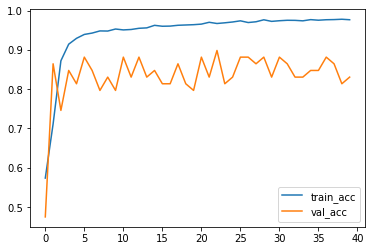

In [105]:
plt.plot(lstm3_h.history['acc'], label='train_acc')
plt.plot(lstm3_h.history['val_acc'], label='val_acc')
plt.legend()

In [107]:
print("Epochs = 40")
print("val_loss length:",len(lstm3_h.history['val_loss']))
print("val_acc length:",len(lstm3_h.history['val_acc']))
print("loss length:",len(lstm3_h.history['loss']))
print("acc length:",len(lstm3_h.history['acc']))

print("Average Training loss =", sum(lstm3_h.history['loss'])/len(lstm3_h.history['loss']))
print("Average Training accuracy=", sum(lstm3_h.history['acc'])/len(lstm3_h.history['acc'])*100)
print("Average validation loss =", sum(lstm3_h.history['val_loss'])/len(lstm3_h.history['val_loss']))
print("Average validation accuracy=", sum(lstm3_h.history['val_acc'])/len(lstm3_h.history['val_acc'])*100)


from keras.utils import plot_model
plot_model(lstm3_model, to_file='results/training_results/LSTM/LSTM3_Loss=BinCE_40EpochsModel.png')


Epochs = 40
val_loss length: 40
val_acc length: 40
loss length: 40
acc length: 40
Average Training loss = 0.5195937075937587
Average Training accuracy= 94.4491872479839
Average validation loss = 0.6649954723624084
Average validation accuracy= 83.3898302167654


In [109]:
lstm3_model.save('Models/LSTM_ThreeLayer_100Epochs.h5')

In [ ]:
# 2 layer LSTM

In [127]:
# 2 Layer LSTM network
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout
from keras.layers import LSTM
from keras import regularizers

adam = optimizers.Adam(lr=0.001)

lstm2_model = Sequential()
lstm2_model.add(BatchNormalization(input_shape=(None, 128)))
lstm2_model.add(Dropout(0.5))

lstm2_model.add(LSTM(64, activation='relu',
        kernel_regularizer=regularizers.l2(0.02),
        activity_regularizer=regularizers.l2(0.02),
        return_sequences=True))


lstm2_model.add(BatchNormalization())
lstm2_model.add(Dropout(0.5))

lstm2_model.add(LSTM(64, activation='relu',
        kernel_regularizer=regularizers.l2(0.02),
        activity_regularizer=regularizers.l2(0.02)))

lstm2_model.add(Dense(1, activation='sigmoid'))

# try using different optimizers and different optimizer configs
lstm2_model.compile(loss='binary_crossentropy',
              optimizer= adam,
              metrics=['accuracy'])


In [128]:
batch_size=32

CV_frac = 0.1
train_gen = data_generator(batch_size,'../data/preprocessed/eval_gunspotting_in_school_subset.tfrecord', 0, 1-CV_frac)
val_gen = data_generator(128,'../data/preprocessed/eval_gunspotting_in_school_subset.tfrecord', 1-CV_frac, 1)

rec_len = 17662

lstm2_h = lstm2_model.fit_generator(train_gen,steps_per_epoch=int(rec_len*(1-CV_frac))//batch_size, epochs=10, 
                       validation_data=val_gen, validation_steps=int(rec_len*CV_frac)//128,
                       verbose=0, callbacks=[TQDMNotebookCallback()])

Total audioframes in eval dataset: 584
After fractioning:
Total audioframes in eval dataset: 59
Total audioframes in eval dataset: 584
After fractioning:
Total audioframes in eval dataset: 525


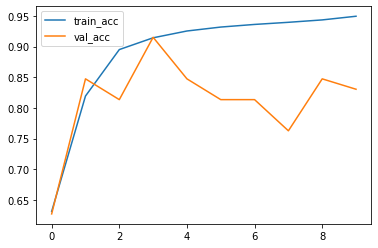

In [129]:
plt.plot(lstm2_h.history['acc'], label='train_acc')
plt.plot(lstm2_h.history['val_acc'], label='val_acc')
plt.legend()

In [130]:
print("Epochs = 25")
print("val_loss length:",len(lstm2_h.history['val_loss']))
print("val_acc length:",len(lstm2_h.history['val_acc']))
print("loss length:",len(lstm2_h.history['loss']))
print("acc length:",len(lstm2_h.history['acc']))

print("Average Training loss =", sum(lstm2_h.history['loss'])/len(lstm2_h.history['loss']))
print("Average Training accuracy=", sum(lstm2_h.history['acc'])/len(lstm2_h.history['acc'])*100)
print("Average validation loss =", sum(lstm2_h.history['val_loss'])/len(lstm2_h.history['val_loss']))
print("Average validation accuracy=", sum(lstm2_h.history['val_acc'])/len(lstm2_h.history['val_acc'])*100)


from keras.utils import plot_model
plot_model(lstm2_model, to_file='results/training_results/LSTM/LSTM3_Loss=BinCE_25EpochsModel.png')


Epochs = 25
val_loss length: 10
val_acc length: 10
loss length: 10
acc length: 10
Average Training loss = 1.6220205805715053
Average Training accuracy= 88.86907762096774
Average validation loss = 0.925989933197315
Average validation accuracy= 81.18644058704376


In [134]:
lstm3_model.save('Models/LSTM_TwoLayer_25Epochs_Valid81.h5')